In [2]:
import xarray
import iris

## Create a target file for ESMF_RegridWeightGen

In [3]:
cs = iris.load_cube('/g/data1a/p66/txz599/data/luc_hist_maps/cableCMIP6_LC_1850.nc')

cs.coord('latitude').guess_bounds()
cs.coord('longitude').guess_bounds()
cs.coord('latitude').units = 'degrees_north'
cs.coord('longitude').units = 'degrees_east'

iris.save(cs, '../land/target_grid.nc', fill_value=1e20)
cs

<iris 'Cube' of veg frac of each PFT / (1) (time: 1; vegtype: 17; latitude: 145; longitude: 192)>

## Create a source file for ESMF_RegridWeightGen

In [4]:
ds = xarray.open_dataset('../land/states_luh2_2.1low.nc', decode_times=False, chunks={'time': 1})
ds.lat.attrs['bounds'] = 'lat_bounds'
ds.lon.attrs['bounds'] = 'lon_bounds'

# Make sure output is masked properly
encoding = {}
for k, v in ds.items():
    if 'missing_value' in v.encoding:
        encoding[k] = {'_FillValue': v.encoding['missing_value']}

ds.isel(time=0).to_netcdf('../land/source_grid.nc', encoding=encoding)

In [5]:
ds.coords['year'] = (ds.time + 850).astype('i4')

In [6]:
for name, var in ds.items():
    print(name, var.attrs.get('long_name',None))

primf forested primary land
primn non-forested primary land
secdf potentially forested secondary land
secdn potentially non-forested secondary land
urban urban land
c3ann C3 annual crops
c4ann C4 annual crops
c3per C3 perennial crops
c4per C4 perennial crops
c3nfx C3 nitrogen-fixing crops
pastr managed pasture
range rangeland
secmb secondary mean biomass carbon density
secma secondary mean age
lat_bounds None
lon_bounds None
time_bnds None


In [7]:
types = list(ds.keys())[:-5]
types

['primf',
 'primn',
 'secdf',
 'secdn',
 'urban',
 'c3ann',
 'c4ann',
 'c3per',
 'c4per',
 'c3nfx',
 'pastr',
 'range']

In [8]:
L = xarray.concat([ds[t] for t in types], dim='type')
L.coords['type'] = types

L

,Array,Chunk
Bytes,58.03 GB,4.15 MB
Shape,"(12, 1166, 720, 1440)","(1, 1, 720, 1440)"
Count,41988 Tasks,13992 Chunks
Type,float32,numpy.ndarray


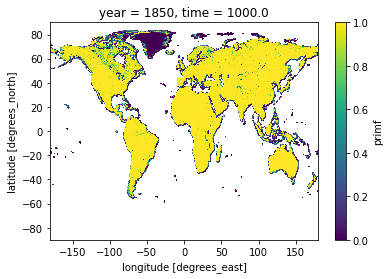

In [9]:
L.isel(time=1000).sum('type', min_count=1).plot()

In [10]:
import climtas.regrid

weights = xarray.open_dataset('../land/weights.nc')
L_regrid = climtas.regrid.regrid(L, weights=weights)

L_regrid

,Array,Chunk
Bytes,3.12 GB,222.72 kB
Shape,"(12, 1166, 145, 192)","(1, 1, 145, 192)"
Count,167919 Tasks,13992 Chunks
Type,float64,numpy.ndarray


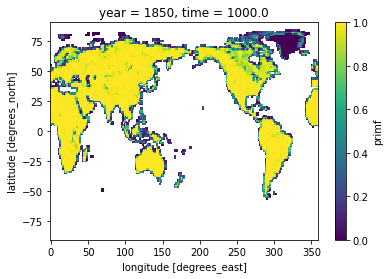

In [12]:
L_regrid.isel(time=1000).sum('type', min_count=1).plot()

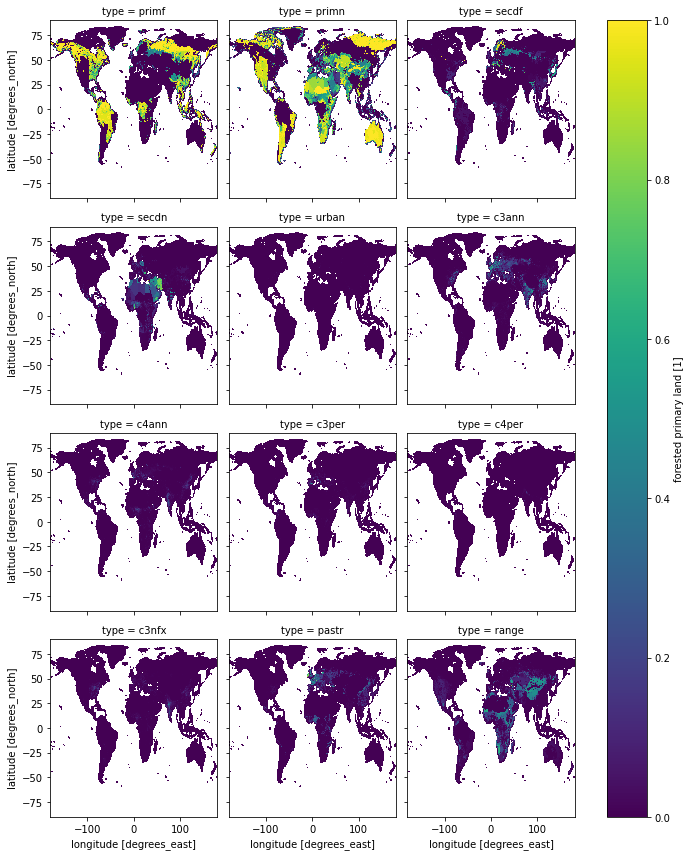

In [17]:
L.isel(time=1000).plot(col='type', col_wrap=3)

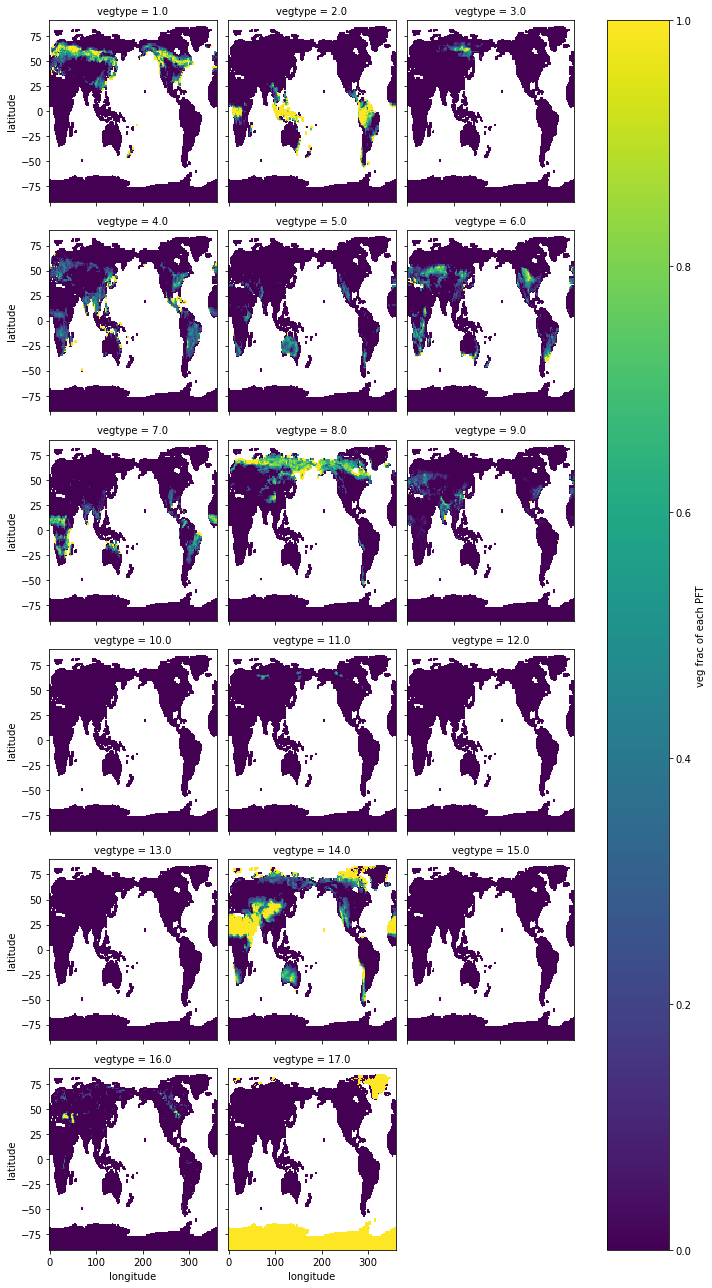

In [22]:
esm_hist = xarray.open_mfdataset('/g/data1a/p66/txz599/data/luc_hist_maps/cableCMIP6_LC_*.nc', combine='nested', concat_dim='time')
esm_hist['fraction'].isel(time=0).plot(col='vegtype', col_wrap=3)